# **Mini Transformer for Dialogue Generation**

## **Ringkasan Teori**

Decoder-Only Transformer: hanya decoder stack dengan
- Token & Positional Embedding
- Masked Multi-Head Self-Attention
- Feed-Forward Network
- Residual + LayerNorm
 
Varian:
- vanilla_small / vanilla_big
- relpos_small / relpos_big (dengan relative positional bias)

## **Setup**

In [96]:
import math, random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import evaluate
import pandas as pd
from IPython.display import display, HTML

In [97]:
def set_seed(s=42):
    random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
set_seed()

In [98]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## **Config**

In [99]:
MAX_SEQ_LEN        = 64
BATCH_SIZE         = 32
NUM_SAMPLES_TRAIN  = 5000
NUM_SAMPLES_TEST   = 200
VAL_SPLIT_RATIO    = 0.1
LEARNING_RATE      = 1e-4

## **Data Loading & EDA**

In [100]:
# load dataset
ds = load_dataset("li2017dailydialog/daily_dialog")
train_all = ds["train"]["dialog"]
test_all  = ds["test"]["dialog"]

In [101]:
train_filtered = [conv for conv in train_all if len(conv) <= 8]
test_filtered  = [conv for conv in test_all  if len(conv) <= 8]

In [102]:
# terapkan NUM_SAMPLES
train_raw = train_filtered[:NUM_SAMPLES_TRAIN]
test_raw  = test_filtered[:NUM_SAMPLES_TEST]

In [104]:
print(f"Train dataset size (≤8 turns): {len(train_raw)}")
print(f"Test  dataset size (≤8 turns): {len(test_raw)}")

Train dataset size (≤8 turns): 5000
Test  dataset size (≤8 turns): 200


In [105]:
# tampilkan 5 contoh
print(">>> 5 contoh train:")
for conv in train_raw[:5]:
    print(" ", conv)
print("\n>>> 5 contoh test:")
for conv in test_raw[:5]:
    print(" ", conv)

>>> 5 contoh train:
  ['Can you do push-ups ? ', " Of course I can . It's a piece of cake ! Believe it or not , I can do 30 push-ups a minute . ", " Really ? I think that's impossible ! ", ' You mean 30 push-ups ? ', ' Yeah ! ', " It's easy . If you do exercise everyday , you can make it , too . "]
  ['Can you study with the radio on ? ', ' No , I listen to background music . ', ' What is the difference ? ', ' The radio has too many comerials . ', " That's true , but then you have to buy a record player . "]
  ['Are you all right ? ', ' I will be all right soon . I was terrified when I watched them fall from the wire . ', " Don't worry.He is an acrobat 。 ", ' I see . ']
  ['Frank ’ s getting married , do you believe this ? ', ' Is he really ? ', ' Yes , he is . He loves the girl very much . ', ' Who is he marring ? ', ' A girl he met on holiday in Spain , I think . ', ' Have they set a date for the wedding ? ', ' Not yet . ']
  ["How are Zina's new programmers working out ? ", " I hate

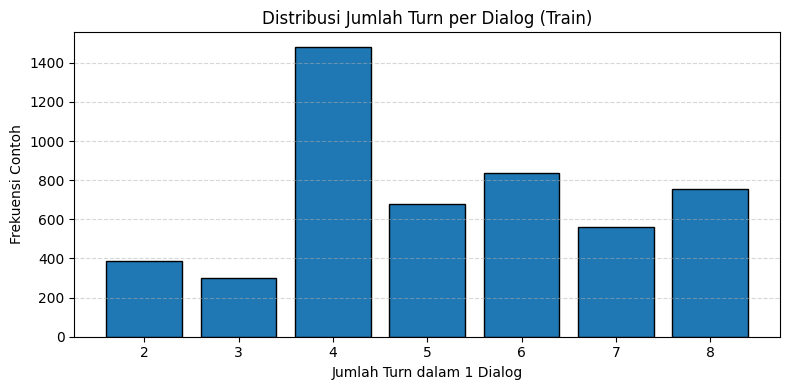

In [106]:
lengths = [len(c) for c in train_raw]
dist    = Counter(lengths)
turns, freqs = zip(*sorted(dist.items()))

# Plot
plt.figure(figsize=(8,4))
plt.bar(turns, freqs, edgecolor='k')
plt.xlabel("Jumlah Turn dalam 1 Dialog")
plt.ylabel("Frekuensi Contoh")
plt.title("Distribusi Jumlah Turn per Dialog (Train)")
plt.xticks(turns)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## **Data Preprocessing (Vocab & Dataset)**

In [107]:
# bangun vocab
token_freq = {}
for conv in train_raw:
    for tok in " [SEP] ".join(conv).split():
        token_freq[tok] = token_freq.get(tok,0) + 1

vocab = ["<pad>","<bos>","<eos>","[SEP]"] + sorted(token_freq, key=token_freq.get, reverse=True)
token2id = {t:i for i,t in enumerate(vocab)}
vocab_size = len(vocab)

In [108]:
# dataset class
class DialogDataset(Dataset):
    def __init__(self, dialogs, tok2id, max_len):
        self.data = []
        for conv in dialogs:
            seq = ["<bos>"] + conv + ["<eos>"]
            ids = [tok2id.get(t,tok2id["<pad>"]) for t in seq]
            ids = ids[:max_len]
            ids += [tok2id["<pad>"]] * (max_len - len(ids))
            self.data.append(torch.tensor(ids))
    def __len__(self): return len(self.data)
    def __getitem__(self, i):
        x = self.data[i][:-1]
        y = self.data[i][1:]
        return x, y

In [109]:
# split train/val
full_ds = DialogDataset(train_raw, token2id, MAX_SEQ_LEN)
val_size = int(len(full_ds) * VAL_SPLIT_RATIO)
train_size = len(full_ds) - val_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

## **Arsitektur Transformer**

In [110]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model%num_heads==0
        self.d_head    = d_model//num_heads
        self.num_heads = num_heads
        self.qkv       = nn.Linear(d_model, 3*d_model)
        self.proj      = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(dropout)
        self.proj_drop = nn.Dropout(dropout)
    def forward(self, x):
        B,T,D = x.shape
        q,k,v = self.qkv(x).chunk(3,-1)
        q = q.view(B,T,self.num_heads,self.d_head).transpose(1,2)
        k = k.view(B,T,self.num_heads,self.d_head).transpose(1,2)
        v = v.view(B,T,self.num_heads,self.d_head).transpose(1,2)
        scores = (q @ k.transpose(-2,-1)) / math.sqrt(self.d_head)
        mask   = torch.tril(torch.ones(T,T,device=x.device)).unsqueeze(0).unsqueeze(0)
        scores = scores.masked_fill(mask==0, float('-inf'))
        attn   = torch.softmax(scores, dim=-1)
        attn   = self.attn_drop(attn)
        out    = (attn @ v).transpose(1,2).contiguous().view(B,T,D)
        return self.proj_drop(self.proj(out))

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.GELU(),
            nn.Linear(d_ff,d_model),
            nn.Dropout(dropout)
        )
    def forward(self,x): return self.net(x)

class DecoderBlock(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout=0.1):
        super().__init__()
        self.ln1  = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttention(d_model,heads,dropout)
        self.ln2  = nn.LayerNorm(d_model)
        self.ff   = FeedForward(d_model,d_ff,dropout)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

class MultiHeadSelfAttentionRelPos(MultiHeadSelfAttention):
    def __init__(self, d_model, num_heads, max_len, dropout=0.1):
        super().__init__(d_model, num_heads, dropout)
        self.max_len  = max_len
        self.rel_bias = nn.Parameter(torch.zeros(num_heads, 2*max_len-1))
        coords = torch.arange(max_len)
        rel_idx = coords[None, :] - coords[:, None] + (max_len - 1)
        self.register_buffer('rel_idx', rel_idx)

    def forward(self, x):
        B, T, D = x.shape
        # QKV
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.view(B, T, self.num_heads, self.d_head).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.d_head).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.d_head).transpose(1, 2)

        # Scaled dot-product
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_head)

        # Add relative bias only for the actual T×T window
        rel_bias_T = self.rel_bias[:, self.rel_idx[:T, :T]]  # (H, T, T)
        scores = scores + rel_bias_T.unsqueeze(0)            # (B, H, T, T)

        # Causal mask
        mask = torch.tril(torch.ones(T, T, device=x.device))
        mask = mask.unsqueeze(0).unsqueeze(0)
        scores = scores.masked_fill(mask == 0, float('-inf'))

        # Attention
        attn = torch.softmax(scores, dim=-1)
        attn = self.attn_drop(attn)   # <— use attn_drop, not attn_dropout
        out  = (attn @ v).transpose(1, 2).contiguous().view(B, T, D)
        return self.proj_drop(self.proj(out))  # <— use proj_drop, not proj_dropout

class DecoderOnlyTransformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.embed   = nn.Embedding(cfg['vocab_size'],cfg['d_model'])
        self.pos_enc = PositionalEncoding(cfg['d_model'],cfg['max_len'])
        self.drop    = nn.Dropout(cfg['dropout'])
        self.layers  = nn.ModuleList()
        for _ in range(cfg['num_layers']):
            block = DecoderBlock(cfg['d_model'],cfg['num_heads'],cfg['d_ff'],cfg['dropout'])
            if cfg.get('relpos',False):
                block.attn = MultiHeadSelfAttentionRelPos(
                    cfg['d_model'],cfg['num_heads'],cfg['max_len'],cfg['dropout'])
            self.layers.append(block)
        self.ln_f = nn.LayerNorm(cfg['d_model'])
        self.head = nn.Linear(cfg['d_model'],cfg['vocab_size'],bias=False)
    def forward(self,x):
        x = self.embed(x)*math.sqrt(x.size(-1))
        x = self.pos_enc(x)
        x = self.drop(x)
        for blk in self.layers: x = blk(x)
        x = self.ln_f(x)
        return self.head(x)
    
def greedy_generate(model, ids, max_new=32, max_len=MAX_SEQ_LEN):
    model.eval()
    out = ids.to(DEVICE)
    with torch.no_grad():
        for _ in range(max_new):
            # keep only the last max_len tokens
            inp = out[:, -max_len:]
            logits = model(inp)
            nt = logits[:, -1, :].argmax(dim=-1, keepdim=True)
            out = torch.cat([out, nt], dim=-1)
            if nt.item() == token2id["<eos>"]:
                break
    return out

In [111]:
# Cell 13. Setup evaluasi
rouge  = evaluate.load("rouge")
bleu   = evaluate.load("bleu")
meteor = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /home/xmriz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/xmriz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/xmriz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## **Pelatihan & Validasi**

In [112]:
experiments = [
    {'name':'vanilla_small','num_layers':2,'d_model': 64,'num_heads':2,'d_ff':256,'relpos':False},
    {'name':'vanilla_big',  'num_layers':2,'d_model':128,'num_heads':4,'d_ff':512,'relpos':False},
    {'name':'relpos_small', 'num_layers':2,'d_model': 64,'num_heads':2,'d_ff':256,'relpos':True},
    {'name':'relpos_big',   'num_layers':2,'d_model':128,'num_heads':4,'d_ff':512,'relpos':True},
]

In [113]:
train_losses, val_losses = {}, {}
for cfg in experiments:
    print(f"\n>>> Training {cfg['name']}")
    conf = {'vocab_size':vocab_size,'max_len':MAX_SEQ_LEN,'dropout':0.1, **cfg}
    model = DecoderOnlyTransformer(conf).to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE)
    crit  = nn.CrossEntropyLoss(ignore_index=token2id["<pad>"])

    tl, vl = [], []
    for epoch in range(1, 6):  # e.g. 5 epochs
        # train
        model.train(); total, n = 0,0
        for x,y in train_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss   = crit(logits.view(-1,vocab_size), y.view(-1))
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item(); n+=1
        tl.append(total/n)

        # valid
        model.eval(); total, n = 0,0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(DEVICE), y.to(DEVICE)
                logits = model(x)
                loss   = crit(logits.view(-1,vocab_size), y.view(-1))
                total += loss.item(); n+=1
        vl.append(total/n)
        print(f" Epoch {epoch}: train={tl[-1]:.4f}, val={vl[-1]:.4f}")

    train_losses[cfg['name']] = tl
    val_losses[cfg['name']]   = vl


>>> Training vanilla_small
 Epoch 1: train=7.8534, val=5.0715
 Epoch 2: train=3.7995, val=2.3034
 Epoch 3: train=1.7068, val=0.8111
 Epoch 4: train=0.6114, val=0.2841
 Epoch 5: train=0.2547, val=0.1367

>>> Training vanilla_big
 Epoch 1: train=4.2070, val=0.8298
 Epoch 2: train=0.4642, val=0.1392
 Epoch 3: train=0.1218, val=0.0565
 Epoch 4: train=0.0588, val=0.0316
 Epoch 5: train=0.0356, val=0.0205

>>> Training relpos_small
 Epoch 1: train=8.6878, val=4.9988
 Epoch 2: train=3.4554, val=1.8743
 Epoch 3: train=1.3938, val=0.6202
 Epoch 4: train=0.5028, val=0.2307
 Epoch 5: train=0.2228, val=0.1169

>>> Training relpos_big
 Epoch 1: train=4.6678, val=0.8248
 Epoch 2: train=0.4645, val=0.1364
 Epoch 3: train=0.1226, val=0.0551
 Epoch 4: train=0.0590, val=0.0308
 Epoch 5: train=0.0357, val=0.0200


## **Visualisasi Loss**

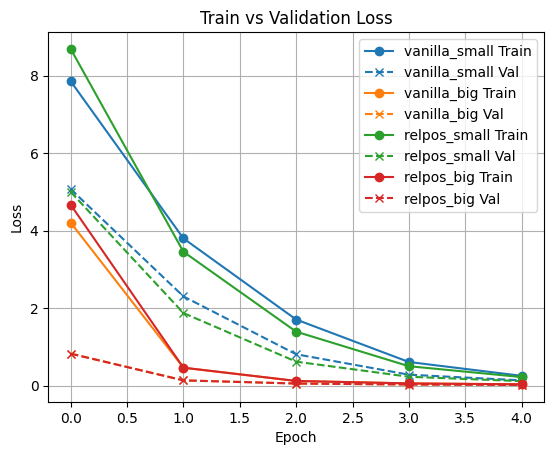

In [114]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
for idx, name in enumerate(train_losses):
    c = colors[idx % len(colors)]  
    plt.plot(train_losses[name],
             marker='o',
             color=c,
             label=f"{name} Train")         
    plt.plot(val_losses[name],
             marker='x',
             linestyle='--',
             color=c,
             label=f"{name} Val")           

plt.title("Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## **Inference & Evaluation**

In [115]:
# Cell 7: Greedy decoding (sudah ada) dan evaluasi test set
preds, refs = [], []
for conv in test_raw:
    prompt = "<bos> " + " [SEP] ".join(conv[:-1]) + " <eos>"
    ids    = [token2id.get(t,token2id["<pad>"]) for t in prompt.split()][:MAX_SEQ_LEN]
    ids   += [token2id["<pad>"]] * (MAX_SEQ_LEN - len(ids))
    input_tensor = torch.tensor([ids]).to(DEVICE)

    out_ids = greedy_generate(model, input_tensor, max_new=32)
    toks    = [vocab[i] for i in out_ids[0].cpu().tolist()]

    # bersihkan <bos>, <pad>, hingga <eos>
    gen = []
    for tok in toks:
        if tok in ("<bos>","<pad>"): continue
        if tok == "<eos>": break
        gen.append(tok)
    preds.append(" ".join(gen).replace("[SEP]"," ").strip())
    refs.append(conv[-1])


In [120]:
# hitung metrik
rouge_res  = rouge.compute(predictions=preds, references=refs)
bleu_res   = bleu.compute(
    predictions=preds,
    references=[[r] for r in refs]    # wrap tiap ref dalam list
)
meteor_res = meteor.compute(predictions=preds, references=refs)

metrics = {
    "Metric": [
        "ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum",
        "BLEU", "BLEU_bp", "METEOR"
    ],
    "Score": [
        rouge_res['rouge1'],
        rouge_res['rouge2'],
        rouge_res['rougeL'],
        rouge_res['rougeLsum'],
        bleu_res['bleu'],
        bleu_res['brevity_penalty'],
        meteor_res['meteor']
    ]
}

df_metrics = pd.DataFrame(metrics)
df_metrics["Score"] = df_metrics["Score"].map(lambda x: f"{x:.4f}")

display(df_metrics.style.set_table_styles([
    {"selector":"th", "props":[("text-align","left")]},
    {"selector":"td", "props":[("text-align","right")]},
    {"selector":"table", "props":[("width","50%"),("margin","0 auto")]}
]))

,Metric,Score
0,ROUGE-1,0.1034
1,ROUGE-2,0.0130
2,ROUGE-L,0.0813
3,ROUGE-Lsum,0.0811
4,BLEU,0.0074
5,BLEU_bp,1.0000
6,METEOR,0.1685


In [119]:
# Ambil 5 contoh pertama
examples    = test_raw[:5]
prompts     = ["<br>".join(conv[:-1]) for conv in examples]  # gunakan <br> sebagai pemisah
references  = refs[:5]
predictions = preds[:5]

# Buat DataFrame
df_examples = pd.DataFrame({
    "Prompt":     prompts,
    "Reference":  references,
    "Prediction": predictions
})

# Atur style agar teks panjang ter‐bungkus, tabel melebar, dan HTML tidak di-escape
styles = [
    {"selector": "th",    "props": [("text-align", "left"), ("font-weight", "bold")]},
    {"selector": "td",    "props": [("text-align", "left"), ("white-space", "pre-wrap")]},
    {"selector": "table", "props": [("width", "100%"), ("table-layout", "fixed")]},
]

# Siapkan Styler tanpa escape HTML
styler = df_examples.style.set_table_styles(styles).set_properties(**{"white-space":"pre-wrap"}).format(escape="html")

# Tampilkan
display(HTML(styler.to_html()))

,Prompt,Reference,Prediction
0,The taxi drivers are on strike again . <br> What for ? <br> They want the government to reduce the price of the gasoline .,It is really a hot potato .,The taxi drivers are on strike again . What for ? They want the government to reduce the price of the gasoline .
1,"We've managed to reduce our energy consumption in our factory by about 15 per cent in the last two years . <br> That's excellent . How have you managed that ? <br> Mainly because we've invested in a heat recovery system . <br> What does that mean exactly ? <br> Well , we use the exhaust gases from our printing presses to provide energy to heat our dryers . <br> What other sources of energy do you use ?",We don't use any fossil fuels . Most of our power comes from hydro-electric plants . We're hoping to use even more energy from alternative sources in the future - perhaps even wind power .,"We've managed to reduce our energy consumption in our factory by about 15 per cent in the last two years . That's excellent . How have you managed that ? because we've invested in a heat recovery system . What does that mean exactly ? Well , we use the from our printing to provide editor"
2,"What are your personal weaknesses ? <br> I ’ m afraid I ’ m a poor talker . I ’ m not comfortable talking with the people whom I have just met for the first time . That is not very good for business , so I have been studying public speaking . <br> Are you more of a leader or a follower ? <br> I don ’ t try to lead people . I ’ d rather cooperate with everybody , and get the job done by working together . <br> Do you think you can make yourself easily understood in English ? <br> Yes , in most circumstances . <br> Are you available for travel ?","Yes , I like travelling . I am young , and unmarried . It ’ s no problem for me to travel frequently .","What are your personal weaknesses ? I ’ m afraid I ’ m a poor . I ’ m not comfortable talking with the people whom I have just met for the first time . That is not very good for business , so I have been studying public speaking . Are you more of a leader or a follower seats"
3,"Hello , this is Mike , Kara . <br> Mike ! Good to hear from you . How are you ? <br> Everything is fine , and how are you ? <br> Things are going well with me . <br> Kara , I had fun the other night at the movies and was wondering if you would like to go out again this Friday . <br> Mike , I don't think that it's a good idea to go out again . I really need to focus on getting packed and ready to move back home . <br> Maybe we could just meet for coffee or something .","I can't really deal with any distractions right now , but I appreciate the nice evening we spent together .","Hello , this is Mike , . Mike ! Good to hear from you . How are you ? Everything is fine , and how are you ? Things are going well with me . , I had fun the other night at the movies and was wondering if you would like to go out again this"
4,"Sun-set hotel . May I help you ? <br> Yes , I have booked a room for 24th . It's a double room . <br> Hold on , please . Let me check it for you . Yes , you're right . You will keep it for 3 days . <br> Well , now I want to change the date from 24th to 28th .","OK , that shall be arranged .","hotel . May I help you ? Yes , I have booked a room for 24th . It's a double room . Hold on , please . Let me check it for you . Yes , you're right . You will keep it for 3 days . Well , now I want to change the date from 24th to please one.It assignments oblong-shaped"


## **Analisis Hasil & Kesimpulan**

In [118]:
# Cell 8: Ranking model per validation loss
best_val = {name: min(val_losses[name]) for name in val_losses}
df_rank  = pd.DataFrame.from_dict(best_val, orient='index', columns=['BestValLoss'])
df_rank  = df_rank.reset_index().rename(columns={'index':'Experiment'})
df_rank  = df_rank.sort_values('BestValLoss').reset_index(drop=True)

print("=== Ranking Model (by Best Val Loss) ===")
print(df_rank.to_string(index=False))

# Ringkasan metrik test set (ambil model terbaik)
best_model = df_rank.loc[0, 'Experiment']
print(f"\nModel terbaik: {best_model}")
print(f"Test ROUGE-1 F1 : {rouge_res['rouge1']:.4f}")
print(f"Test BLEU       : {bleu_res['bleu']:.4f}")
print(f"Test METEOR     : {meteor_res['meteor']:.4f}")

# Kesimpulan
print("\n=== Kesimpulan ===")
print(f"Dari kurva loss dan metrik test, varian **{best_model}** memberikan trade-off terbaik antara training stability dan kualitas generasi dialog.")


=== Ranking Model (by Best Val Loss) ===
   Experiment  BestValLoss
   relpos_big     0.019978
  vanilla_big     0.020543
 relpos_small     0.116872
vanilla_small     0.136720

Model terbaik: relpos_big
Test ROUGE-1 F1 : 0.1034
Test BLEU       : 0.0074
Test METEOR     : 0.1685

=== Kesimpulan ===
Dari kurva loss dan metrik test, varian **relpos_big** memberikan trade-off terbaik antara training stability dan kualitas generasi dialog.
